<a href="https://colab.research.google.com/github/ilham-mukti/Machine-Learning/blob/main/Nyoba_3_3_XGBoost_Klasifikasi_Evaluation_%5BData_Mushrooms%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jcopml

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix

from skopt import BayesSearchCV
from xgboost import XGBRegressor, XGBClassifier

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.tuning import grid_search_params as gsp, random_search_params as rsp
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease
from jcopml.plot import plot_missing_value, plot_confusion_matrix, plot_association_matrix, plot_classification_report
from jcopml.tuning.space import Integer, Real

sns.set()

In [12]:
datas = pd.read_csv("/content/mushrooms.csv")
datas.head()

,edible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,False,convex,smooth,brown,True,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,1,pendant,black,scattered,urban
1,True,convex,smooth,yellow,True,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,1,pendant,brown,numerous,grasses
2,True,bell,smooth,white,True,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,1,pendant,brown,numerous,meadows
3,False,convex,scaly,white,True,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,1,pendant,black,scattered,urban
4,True,convex,smooth,gray,False,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,1,evanescent,brown,abundant,grasses


,missing_value,%
edible,0,0.00
cap_shape,0,0.00
cap_surface,0,0.00
cap_color,0,0.00
bruises,0,0.00
odor,0,0.00
gill_attachment,0,0.00
gill_spacing,0,0.00
gill_size,0,0.00
gill_color,0,0.00


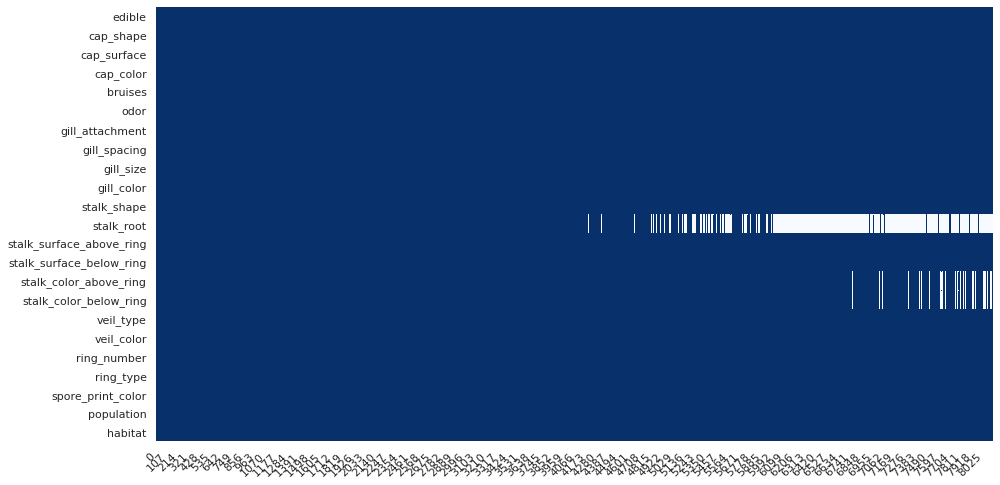

In [14]:
plot_missing_value(datas, return_df=True)

In [15]:
datas.drop(columns='stalk_root', inplace=True)

In [19]:
datas.edible.value_counts(), datas.shape

(True     4208
 False    3916
 Name: edible, dtype: int64, (8124, 22))

In [99]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   edible                    8124 non-null   bool  
 1   cap_shape                 8124 non-null   object
 2   cap_surface               8124 non-null   object
 3   cap_color                 8124 non-null   object
 4   bruises                   8124 non-null   bool  
 5   odor                      8124 non-null   object
 6   gill_attachment           8124 non-null   object
 7   gill_spacing              8124 non-null   object
 8   gill_size                 8124 non-null   object
 9   gill_color                8124 non-null   object
 10  stalk_shape               8124 non-null   object
 11  stalk_surface_above_ring  8124 non-null   object
 12  stalk_surface_below_ring  8124 non-null   object
 13  stalk_color_above_ring    7932 non-null   object
 14  stalk_color_below_ring  

In [26]:
plot_association_matrix(datas, 'edible', categoric_col='auto')

ValueError: ignored

In [27]:
datas.veil_type.value_counts()

partial    8124
Name: veil_type, dtype: int64

In [29]:
datas.drop(columns='veil_type', inplace=True)

In [38]:
plot_association_matrix(datas, 'edible', categoric_col='auto') #Kebetulan ini kategori semua, pake AUTO. Kalo ada numerik pake juga korelasi matriks

interactive(children=(ToggleButtons(description='method', options=("Cramer's V", 'Proficiency U(X|Y)', 'Profic…

In [106]:
X = datas[['odor', 'gill_color', 'ring_type', 'spore_print_color']]
y = datas['edible']*1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape

((6499, 4), (1625, 4))

In [ ]:
preprocessor = ColumnTransformer([
    ('cat_data', cat_pipe(impute='most_frequent', encoder='onehot'), X_train.columns),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42)),
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

In [109]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9932297276504077, 0.9975384615384615)

# MINI EDA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

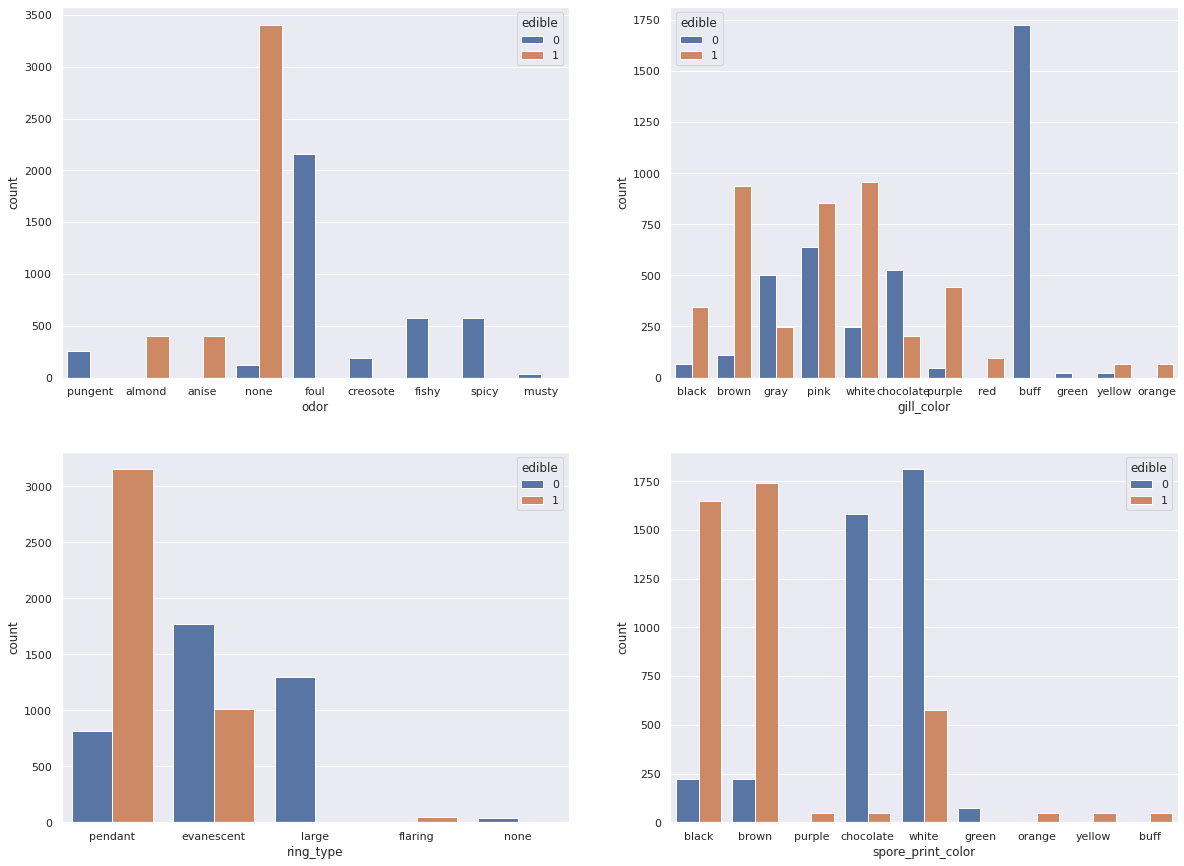

In [110]:
cat_var = X_train.columns
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

for cat, ax in zip(cat_var, axes.flatten()):
  sns.countplot(cat, data=datas, hue=y, ax=ax)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

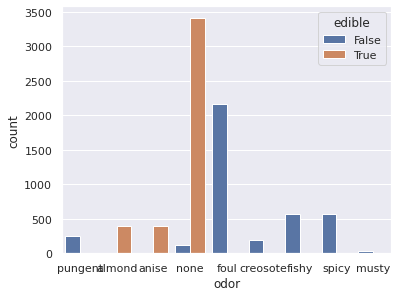

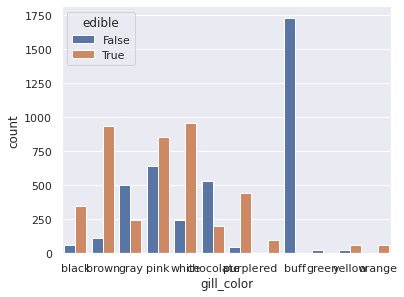

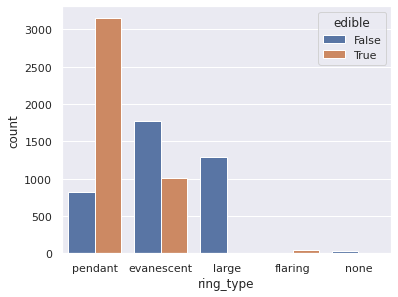

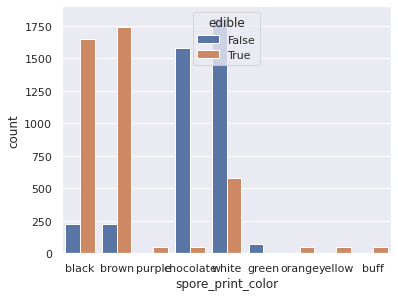

In [111]:
cat_var = X_train.columns
i = 221
for cat in cat_var:
  plt.figure(figsize=(13,10))
  plt.subplot(i)
  sns.countplot(cat, data=datas, hue='edible')
  i+=1

# EVALUATION

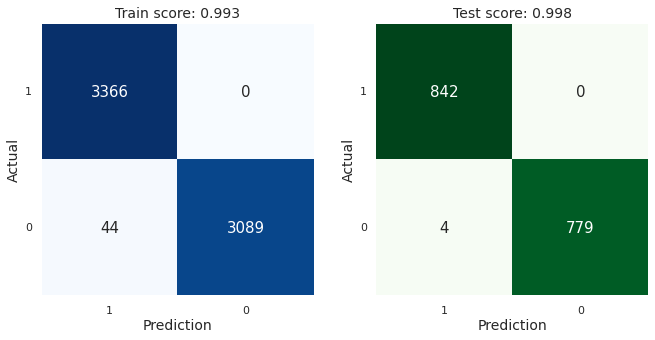

In [112]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [113]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3133
           1       0.99      1.00      0.99      3366

    accuracy                           0.99      6499
   macro avg       0.99      0.99      0.99      6499
weighted avg       0.99      0.99      0.99      6499


Test report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       783
           1       1.00      1.00      1.00       842

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [115]:
# Liat data yang error, cek deh
datas_analisis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

datas_analisis['edible'] = y_train
datas_analisis['prediksi'] = pred
datas_analisis['error'] = error
datas_analisis = datas_analisis[datas_analisis.error > 0]
datas_analisis.head()

,odor,gill_color,ring_type,spore_print_color,edible,prediksi,error
5964,none,white,evanescent,white,0,1,1
7600,none,white,evanescent,white,0,1,1
5128,none,white,pendant,white,0,1,1
5361,none,white,evanescent,white,0,1,1
5001,none,white,evanescent,white,0,1,1


In [117]:
datas_analisis.value_counts()

odor  gill_color  ring_type   spore_print_color  edible  prediksi  error
none  white       evanescent  white              0       1         1        33
                  pendant     white              0       1         1         7
      yellow      evanescent  white              0       1         1         4
dtype: int64